# Exploring in Ho Chi Minh City

This assignment is to explore places in Ho Chi Minh City which is the biggest city in Vietnam, attracting millions of tourists every year. The city is famous for historic palaces, fancy restaurants, crowded marketplaces and numerous coffee shops. This assignment answers some important business questions as below:

- What are the population density and land cost in each district? 
- How are these indicators connected?
- What are the most common venues in each urban district in Ho Chi Minh City?
- Cluster and visualize districts based on their common characteristics

Data is taken from:
- https://en.wikipedia.org/wiki/Ho_Chi_Minh_City for administration units
- https://mogi.vn/gia-nha-dat for land costs
- https://nominatim.openstreetmap.org/ for latitude and longitude
- Foursquare API for information about venues 

### Import necessary libraries

In [1]:
# Handle data in a vectorized manner
import numpy as np

# Data analysis
import pandas as pd

# Convert an address into latitude and longitude values
import geopy
from geopy.geocoders import Nominatim

# Request data
from bs4 import BeautifulSoup
import requests

# Map
import folium

# Remove Vietnamese accents
from unidecode import unidecode

%matplotlib inline
import matplotlib.pyplot as plt

### Get data about urban districts

In [2]:
# Get data from Wiki
source = requests.get("https://en.wikipedia.org/wiki/Ho_Chi_Minh_City").text
soup = BeautifulSoup(source, 'lxml')
table = (soup.find("span", {"id": "Demographics"}).parent.previous_sibling.previous_sibling)

table_rows = table.tbody.find_all("tr")
res_hcm = []
for tr in table_rows:
    td = tr.find_all("td")
    row = [tr.text for tr in td]
    res_hcm.append(row)

In [3]:
# Create a data frame
df=pd.DataFrame(res_hcm, columns=['District', 'Subdistrict', 'Area_km2', '', '','', '', 'Population_2015',''])
df.drop('', axis=1, inplace=True)
df['Population_2015'] = (df['Population_2015'].str.replace("\n", "")
                         .str.replace(",", "")
                         .str.replace(".", "")
                         .str.strip())
df_hcm=df.iloc[3:22].reset_index().drop('index', axis=1)
df_hcm['Density']=round(df_hcm['Population_2015'].astype(float)/df_hcm['Area_km2'].astype(float),2)
df_hcm['District']=df_hcm['District'].str.replace(" District","")
df_hcm['District']=df_hcm['District'].str.replace("District ","")
df_hcm['District']=df_hcm['District'].apply(unidecode)
df_hcm.head()

,District,Subdistrict,Area_km2,Population_2015,Density
0,1,10 wards,7.73,193632,25049.42
1,2,11 wards,49.74,147168,2958.75
2,3,14 wards,4.92,196333,39905.08
3,4,15 wards,4.18,186727,44671.53
4,5,15 wards,4.27,178615,41830.21


In [4]:
# change type of data
df_hcm['Area_km2'] = df_hcm['Area_km2'].astype(float)
df_hcm['Population_2015'] = df_hcm['Population_2015'].astype(float)

# reset index to draw maps
df_hcm.set_index('District', inplace=True)
df_hcm.dtypes

Subdistrict         object
Area_km2           float64
Population_2015    float64
Density            float64
dtype: object

In [5]:
# summarize
pop = df_hcm['Population_2015'].sum()
area = round(df_hcm['Area_km2'].sum(),2)
print('Total population of HCMC in 2015: {} people'.format(pop))
print('Total urban area of HCMC: {} km2'.format(area))

Total population of HCMC in 2015: 6616684.0 people
Total urban area of HCMC: 496.01 km2


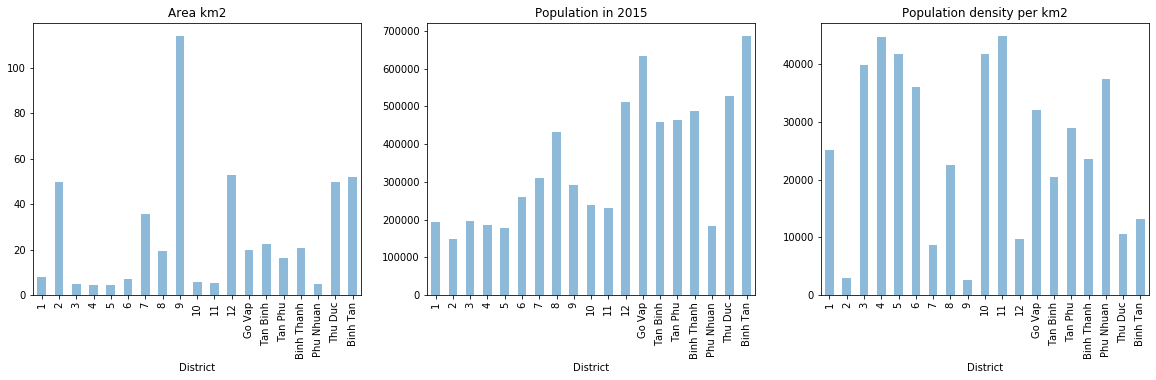

In [6]:
# bar charts of area and population
fig = plt.figure(figsize = (20,5))

ax0 = fig.add_subplot(1,3,1)
ax1 = fig.add_subplot(1,3,2)
ax2 = fig.add_subplot(1,3,3)
ax0.title.set_text('Area km2')
ax1.title.set_text('Population in 2015')
ax2.title.set_text('Population density per km2')

df_hcm['Area_km2'].plot(kind = 'bar', ax = ax0, alpha = 0.5, stacked = False)
df_hcm['Population_2015'].plot(kind = 'bar', ax = ax1, alpha = 0.5, stacked = False)
df_hcm['Density'].plot(kind = 'bar', ax = ax2, alpha = 0.5, stacked = False)

District 9 has the largest area while Binh Tan District has the biggest population. District 5 and 11 are the ones that have highest population density.

### Get housing prices

In [7]:
# get data from Mogi
source_price = requests.get("https://mogi.vn/gia-nha-dat").text
soup = BeautifulSoup(source_price, 'lxml')
table_price = soup.find("div", class_="mt-table")
table_rows = table_price.find_all("div", class_="mt-row")
res_price = []
for tr in table_rows:
    district = tr.find("div", class_="mt-street").a.text
    medium_price = tr.find("div", class_="mt-vol").span.text
    row = [district, medium_price]
    res_price.append(row)

In [12]:
# set up a dataframe
df_price=pd.DataFrame(res_price, columns=['District', 'Price_mVND_per_sqm'])

df_price['District'] = df_price['District'].apply(unidecode)
df_price['Price_mVND_per_sqm'] = df_price['Price_mVND_per_sqm'].apply(unidecode)

df_price['District']=(df_price['District'].str.replace('\n', '')
                      .str.replace('Quan ','')
                      .str.replace('Huyen ',''))
df_price['Price_mVND_per_sqm']=(df_price['Price_mVND_per_sqm'].str.replace('trieu/m2','')
                                .str.replace(',','.'))

df_price.head()

,District,Price_mVND_per_sqm
0,1,418
1,2,81.4
2,3,265
3,4,109
4,5,254


In [13]:
# merge data
df_merge = pd.merge(df_hcm, df_price, how='left', left_on='District', right_on='District')
df_merge['District'] = df_merge['District'].str.replace('Go Vap', 'GoVap')
df_merge.head()

,District,Subdistrict,Area_km2,Population_2015,Density,Price_mVND_per_sqm
0,1,10 wards,7.73,193632.0,25049.42,418
1,2,11 wards,49.74,147168.0,2958.75,81.4
2,3,14 wards,4.92,196333.0,39905.08,265
3,4,15 wards,4.18,186727.0,44671.53,109
4,5,15 wards,4.27,178615.0,41830.21,254


### Get latitude and longitude of each district

In [14]:
def find_coord (name):
    address = name + ' Ho Chi Minh City'
    location = Nominatim(user_agent='hcmc').geocode(address)
    lat = location.latitude
    lon = location.longitude
    return [lat, lon]
    
coord = [find_coord('District ' + dist) for dist in df_merge['District'].iloc[:12].tolist()]
coord = coord + [find_coord (dist + ' District') for dist in df_merge['District'].iloc[12:].tolist()]
df_coord=pd.DataFrame(coord, columns=['Latitude', 'Longitude'])

df_merge['Latitude'] = df_coord['Latitude']
df_merge['Longitude'] = df_coord['Longitude']

df_merge.head()

,District,Subdistrict,Area_km2,Population_2015,Density,Price_mVND_per_sqm,Latitude,Longitude
0,1,10 wards,7.73,193632.0,25049.42,418,10.774540,106.699184
1,2,11 wards,49.74,147168.0,2958.75,81.4,10.804963,106.747470
2,3,14 wards,4.92,196333.0,39905.08,265,10.775844,106.701756
3,4,15 wards,4.18,186727.0,44671.53,109,10.759243,106.704890
4,5,15 wards,4.27,178615.0,41830.21,254,10.756129,106.670376


In [15]:
# Change datatype
df_merge['Price_mVND_per_sqm']=df_merge['Price_mVND_per_sqm'].astype(float)
df_merge.dtypes

District               object
Subdistrict            object
Area_km2              float64
Population_2015       float64
Density               float64
Price_mVND_per_sqm    float64
Latitude              float64
Longitude             float64
dtype: object

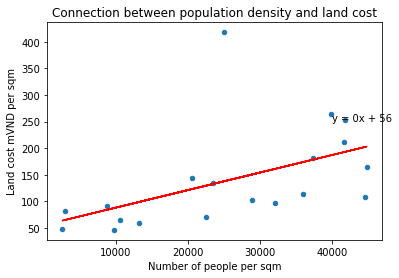

In [16]:
# scatter chart to demonstrate relationship between population density and land cost
x = df_merge['Density']
y = df_merge['Price_mVND_per_sqm']
fit = np.polyfit(x, y, deg = 1)

df_merge.plot(kind='scatter', x='Density', y='Price_mVND_per_sqm')

plt.plot(x, fit[0]*x + fit[1], color='red')
plt.annotate('y = {0:.0f}x + {1:.0f}'.format(fit[0], fit[1]), xy=(40000,250))

plt.title('Connection between population density and land cost')
plt.xlabel('Number of people per sqm')
plt.ylabel('Land cost mVND per sqm')
plt.show()

There is a positive correlation between population density and the land cost. However, the correlation is not strongly positive as x is near to 0

### Map of each district

In [17]:
# Map of Ho Chi Minh City
address = 'Ho Chi Minh City'
location = Nominatim(user_agent='hcmc').geocode(address)
latitude = location.latitude
longitude = location.longitude

map_hcm = folium.Map(location = [latitude, longitude], zoom_start=12)

for lat, lon, label in zip (df_merge['Latitude'], df_merge['Longitude'], df_merge['District']):
    label = folium.Popup ('District ' + label, parse_html = True)
    folium.CircleMarker ([lat, lon],
                         radius = 5,
                         popup = label,
                         fill = True,
                         fill_color = 'blue',
                         fill_opacity = 0.7
                        ).add_to(map_hcm)
map_hcm

### Explore venues in all districts

In [18]:
CLIENT_ID = 'XOG5WQ43GVCYRKZVLBFHTZTWGHNDJ0JS0FNZZZUTINAXL1JB'
CLIENT_SECRET = 'DLZLVRFA5RXVND4BB2JZ4O45ZTNTHKNEMTXQELECOR0MDO3E'
VERSION = '20140715'

In [19]:
limit=100
radius=500

#def getNearbyVenues(names, latitudes, longitudes):
venues_list=[]
for name, lat, lon in zip (df_merge['District'], df_merge['Latitude'], df_merge['Longitude']):
    url='https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lon, 
        radius, 
        limit)
       
    results = requests.get(url).json()['response']['groups'][0]['items']
        
    venues_list.append([(name,
                             lat,
                             lon,
                             v['venue']['name'],
                             v['venue']['location']['lat'],
                             v['venue']['location']['lng'],
                             v['venue']['categories'][0]['name'] 
                             ) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District_Latitude', 
                  'District_Longitude', 
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
nearby_venues.head()
#return (nearby_venues)

,District,District_Latitude,District_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,1,10.77454,106.699184,Pizza 4P's,10.773301,106.697599,Pizza Place
1,1,10.77454,106.699184,Liberty Central Saigon Citypoint Hotel,10.774758,106.700795,Hotel
2,1,10.77454,106.699184,Pasteur Street Brewing Company,10.775220,106.700894,Brewery
3,1,10.77454,106.699184,CGV Cinemas Liberty CityPoint,10.774763,106.700766,Multiplex
4,1,10.77454,106.699184,Saxn'art Jazz Club,10.774068,106.700905,Jazz Club


In [20]:
nearby_venues.shape

(359, 7)

In [21]:
# onehot encoding
hcm_onehot = pd.get_dummies (nearby_venues[['Venue_Category']],
                            prefix='',
                            prefix_sep='')
hcm_onehot['District'] = nearby_venues['District']
fixed_columns = [hcm_onehot.columns[-1]] + list(hcm_onehot.columns[:-1])
hcm_onehot = hcm_onehot[fixed_columns]

hcm_group = hcm_onehot.groupby('District').mean().reset_index()
hcm_group

,District,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bar,...,Tennis Court,Thai Restaurant,Theater,Travel Agency,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar
0,1,0.00,0.00,0.00,0.000000,0.040000,0.00,0.030000,0.01,0.03,...,0.00,0.00,0.00,0.0,0.01,0.01,0.000000,0.140000,0.00,0.01
1,10,0.00,0.00,0.00,0.038462,0.000000,0.00,0.000000,0.00,0.00,...,0.00,0.00,0.00,0.0,0.00,0.00,0.000000,0.192308,0.00,0.00
2,11,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,...,0.00,0.00,0.00,0.0,0.00,0.00,0.000000,0.000000,0.00,0.00
3,12,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,...,0.00,0.00,0.00,0.0,0.00,0.00,0.000000,0.250000,0.00,0.00
4,2,0.00,0.00,0.05,0.000000,0.150000,0.00,0.000000,0.00,0.00,...,0.05,0.00,0.00,0.0,0.05,0.00,0.000000,0.000000,0.00,0.00
5,3,0.00,0.01,0.00,0.000000,0.010000,0.01,0.020000,0.00,0.03,...,0.00,0.03,0.01,0.0,0.02,0.01,0.000000,0.070000,0.00,0.01
6,4,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,...,0.00,0.00,0.00,0.0,0.00,0.00,0.000000,0.181818,0.00,0.00
7,5,0.00,0.00,0.00,0.000000,0.037037,0.00,0.037037,0.00,0.00,...,0.00,0.00,0.00,0.0,0.00,0.00,0.000000,0.111111,0.00,0.00
8,6,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,...,0.00,0.00,0.00,0.0,0.00,0.00,0.000000,0.000000,0.00,0.00
9,7,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,...,0.00,0.00,0.00,0.0,0.00,0.00,0.000000,0.375000,0.00,0.00


In [22]:
def return_most_common_venues (row, num_top_venues):
    row_categories = row.iloc[1:].sort_values(ascending = False)
    return row_categories.index.values[0:num_top_venues]

In [23]:
num_top_venues = 10
indicators = ['st','nd','rd']
columns = ['District']

for i in np.arange(num_top_venues):
    try:
        columns.append ('{}{} Most common venue'.format(i+1), indicators [i])
    except:
        columns.append ('{}th Most common venue'.format(i+1))
    
venue_sorted = pd.DataFrame (columns=columns)
venue_sorted['District'] = hcm_group['District']

In [24]:
# find the top 10 most common venues at each district
for i in np.arange(hcm_group.shape[0]):
    venue_sorted.iloc[i,1:] = return_most_common_venues(hcm_group.iloc[i,:], num_top_venues)
venue_sorted

,District,1th Most common venue,2th Most common venue,3th Most common venue,4th Most common venue,5th Most common venue,6th Most common venue,7th Most common venue,8th Most common venue,9th Most common venue,10th Most common venue
0,1,Vietnamese Restaurant,Hotel,Café,Coffee Shop,Asian Restaurant,Clothing Store,BBQ Joint,Multiplex,Burger Joint,Bar
1,10,Café,Vietnamese Restaurant,Coffee Shop,Bookstore,Multiplex,Arts & Crafts Store,Hotpot Restaurant,Sushi Restaurant,Korean Restaurant,Steakhouse
2,11,Café,Pizza Place,Eastern European Restaurant,Cocktail Bar,Coffee Shop,Convention Center,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant
3,12,Vietnamese Restaurant,Food Truck,Dessert Shop,Chinese Restaurant,Whisky Bar,Eastern European Restaurant,Cocktail Bar,Coffee Shop,Convention Center,Cupcake Shop
4,2,Café,Asian Restaurant,Restaurant,Shopping Mall,Buffet,Department Store,Movie Theater,Coffee Shop,Residential Building (Apartment / Condo),Market
5,3,Hotel,Coffee Shop,Café,Vietnamese Restaurant,Thai Restaurant,Bar,French Restaurant,Multiplex,Massage Studio,Clothing Store
6,4,Seafood Restaurant,Vietnamese Restaurant,Snack Place,Furniture / Home Store,Japanese Restaurant,Whisky Bar,Dumpling Restaurant,Cocktail Bar,Coffee Shop,Convention Center
7,5,Noodle House,Chinese Restaurant,Coffee Shop,Dim Sum Restaurant,Vietnamese Restaurant,Convention Center,Asian Restaurant,Hotel,Dessert Shop,Seafood Restaurant
8,6,Café,Electronics Store,Cocktail Bar,Coffee Shop,Convention Center,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Dumpling Restaurant
9,7,Vietnamese Restaurant,Café,Flea Market,Coffee Shop,Eastern European Restaurant,Cocktail Bar,Convention Center,Cupcake Shop,Department Store,Dessert Shop


### Cluster districts

In [25]:
# cluster districts into 3 groups
from sklearn.cluster import KMeans
k=3
hcm_cluster = hcm_group.drop('District', axis=1)
kmeans = KMeans(n_clusters = k, random_state = 0).fit(hcm_cluster)

In [26]:
venue_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [27]:
hcm_merge = df_merge[['District', 'Latitude', 'Longitude']]
hcm_merge = hcm_merge.join(venue_sorted.set_index('District'), on = 'District')
hcm_merge.head()

,District,Latitude,Longitude,Cluster Labels,1th Most common venue,2th Most common venue,3th Most common venue,4th Most common venue,5th Most common venue,6th Most common venue,7th Most common venue,8th Most common venue,9th Most common venue,10th Most common venue
0,1,10.774540,106.699184,1,Vietnamese Restaurant,Hotel,Café,Coffee Shop,Asian Restaurant,Clothing Store,BBQ Joint,Multiplex,Burger Joint,Bar
1,2,10.804963,106.747470,1,Café,Asian Restaurant,Restaurant,Shopping Mall,Buffet,Department Store,Movie Theater,Coffee Shop,Residential Building (Apartment / Condo),Market
2,3,10.775844,106.701756,1,Hotel,Coffee Shop,Café,Vietnamese Restaurant,Thai Restaurant,Bar,French Restaurant,Multiplex,Massage Studio,Clothing Store
3,4,10.759243,106.704890,1,Seafood Restaurant,Vietnamese Restaurant,Snack Place,Furniture / Home Store,Japanese Restaurant,Whisky Bar,Dumpling Restaurant,Cocktail Bar,Coffee Shop,Convention Center
4,5,10.756129,106.670376,1,Noodle House,Chinese Restaurant,Coffee Shop,Dim Sum Restaurant,Vietnamese Restaurant,Convention Center,Asian Restaurant,Hotel,Dessert Shop,Seafood Restaurant


In [28]:
# setting colors for each cluster
map_cluster = folium.Map(location = [latitude, longitude], zoom_start=12)

import matplotlib.cm as cm
import matplotlib.colors as colors

x = np.arange(k)
y = [i + x + (i * x) **2 for i in range (k)]
colors_array = cm.rainbow(np.linspace(0,1,len(y)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [29]:
marker_color=[]
for lat, lon, dis, cluster in zip (hcm_merge['Latitude'], hcm_merge['Longitude'], hcm_merge['District'], hcm_merge['Cluster Labels']):
    label = folium.Popup('District '+str(dis)+'- Cluster '+str(cluster), parse_html= False)
    folium.CircleMarker([lat, lon],
                        radius=5,
                        popup=label,
                        color=rainbow[cluster-1],
                        fill=True,
                        fill_color=rainbow[cluster-1]
                       ).add_to(map_cluster)
map_cluster

### Examine each cluster

In [30]:
hcm_merge.loc[hcm_merge['Cluster Labels']==0,:]

,District,Latitude,Longitude,Cluster Labels,1th Most common venue,2th Most common venue,3th Most common venue,4th Most common venue,5th Most common venue,6th Most common venue,7th Most common venue,8th Most common venue,9th Most common venue,10th Most common venue
7,8,10.747343,106.666116,0,Vietnamese Restaurant,Food Truck,Dessert Shop,Chinese Restaurant,Whisky Bar,Eastern European Restaurant,Cocktail Bar,Coffee Shop,Convention Center,Cupcake Shop
8,9,10.747343,106.666116,0,Vietnamese Restaurant,Food Truck,Dessert Shop,Chinese Restaurant,Whisky Bar,Eastern European Restaurant,Cocktail Bar,Coffee Shop,Convention Center,Cupcake Shop
11,12,10.747343,106.666116,0,Vietnamese Restaurant,Food Truck,Dessert Shop,Chinese Restaurant,Whisky Bar,Eastern European Restaurant,Cocktail Bar,Coffee Shop,Convention Center,Cupcake Shop


In [31]:
hcm_merge.loc[hcm_merge['Cluster Labels']==1,:]

,District,Latitude,Longitude,Cluster Labels,1th Most common venue,2th Most common venue,3th Most common venue,4th Most common venue,5th Most common venue,6th Most common venue,7th Most common venue,8th Most common venue,9th Most common venue,10th Most common venue
0,1,10.774540,106.699184,1,Vietnamese Restaurant,Hotel,Café,Coffee Shop,Asian Restaurant,Clothing Store,BBQ Joint,Multiplex,Burger Joint,Bar
1,2,10.804963,106.747470,1,Café,Asian Restaurant,Restaurant,Shopping Mall,Buffet,Department Store,Movie Theater,Coffee Shop,Residential Building (Apartment / Condo),Market
2,3,10.775844,106.701756,1,Hotel,Coffee Shop,Café,Vietnamese Restaurant,Thai Restaurant,Bar,French Restaurant,Multiplex,Massage Studio,Clothing Store
3,4,10.759243,106.704890,1,Seafood Restaurant,Vietnamese Restaurant,Snack Place,Furniture / Home Store,Japanese Restaurant,Whisky Bar,Dumpling Restaurant,Cocktail Bar,Coffee Shop,Convention Center
4,5,10.756129,106.670376,1,Noodle House,Chinese Restaurant,Coffee Shop,Dim Sum Restaurant,Vietnamese Restaurant,Convention Center,Asian Restaurant,Hotel,Dessert Shop,Seafood Restaurant
6,7,10.736573,106.722432,1,Vietnamese Restaurant,Café,Flea Market,Coffee Shop,Eastern European Restaurant,Cocktail Bar,Convention Center,Cupcake Shop,Department Store,Dessert Shop
9,10,10.773198,106.667833,1,Café,Vietnamese Restaurant,Coffee Shop,Bookstore,Multiplex,Arts & Crafts Store,Hotpot Restaurant,Sushi Restaurant,Korean Restaurant,Steakhouse
12,GoVap,10.847072,106.669609,1,Grocery Store,Food Truck,Boutique,Warehouse Store,Furniture / Home Store,French Restaurant,Cocktail Bar,Coffee Shop,Convention Center,Cupcake Shop
13,Tan Binh,10.797979,106.653805,1,Gym / Fitness Center,Sushi Restaurant,Fast Food Restaurant,Multiplex,Breakfast Spot,Stadium,Steakhouse,Supermarket,Bubble Tea Shop,BBQ Joint
14,Tan Phu,10.791640,106.627302,1,Café,Vietnamese Restaurant,Coffee Shop,BBQ Joint,Electronics Store,Cocktail Bar,Convention Center,Cupcake Shop,Department Store,Dessert Shop


In [32]:
hcm_merge.loc[hcm_merge['Cluster Labels']==2,:]

,District,Latitude,Longitude,Cluster Labels,1th Most common venue,2th Most common venue,3th Most common venue,4th Most common venue,5th Most common venue,6th Most common venue,7th Most common venue,8th Most common venue,9th Most common venue,10th Most common venue
5,6,10.746928,106.634495,2,Café,Electronics Store,Cocktail Bar,Coffee Shop,Convention Center,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Dumpling Restaurant
10,11,10.764208,106.643282,2,Café,Pizza Place,Eastern European Restaurant,Cocktail Bar,Coffee Shop,Convention Center,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant


### Conclusion

- District 9 has the largest area while Binh Tan District has the biggest population. District 5 and 11 are the ones that have highest population density.
- There is a positive correlation between population density and the land cost. However, the correlation coefficient is not strongly positive.
- The most common venues in HCMC urban districts are Vietnamese restaurants and cafe/coffee shops
- There are 3 clusters, 13 out of 19 urban districts share the same characteristics and are grouped in cluster no.1. District 8,9 and 12 are in cluster no.0 due to the popularity of food trucks, desert shops and Chinese restaurants. Finally, district 6 and 11 are in cluster no.2.